# High-Performance Quanvolutional Neural Networks with JAX & Flax

**Author:** Spartoons  
**Based on:** [PennyLane Quanvolutional Neural Networks Tutorial](https://pennylane.ai/qml/demos/tutorial_quanvolution) (Apache 2.0)

## Overview
This project is a port of the classic PennyLane "Quanvolution" tutorial from TensorFlow/Keras to the **JAX/Flax** ecosystem. 

The primary goal of this implementation is to demonstrate high-performance quantum simulation by leveraging JAX's **Just-In-Time (JIT) compilation** and **automatic vectorization (`vmap`)**. 

### Key Improvements
* **Vectorized Quantum Execution:** Instead of iterating over image patches with Python loops, we use `jax.vmap` to process all patches in a batch simultaneously.
* **JAX/Flax Training Loop:** A custom, stateless training loop allows for fine-grained control over optimization steps.

## 1. Imports and Setup
We utilize `PennyLane` for quantum circuits, `JAX` for high-performance numerical computing, and `Flax` for building the neural network. `Optax` provides the optimization logic.

In [10]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import jax
import jax.numpy as jnp
from datasets import load_dataset
import matplotlib.pyplot as plt
import os
import flax.linen as nn
from flax.training import train_state
import optax

## 2. Configuration & Hyperparameters
**Critical Setup:** We enable JAX 64-bit precision (`jax_enable_x64`). Quantum simulations often require high numerical precision to maintain unitary constraints; running in default 32-bit mode can sometimes lead to numerical instability in gradient calculations.

In [11]:
# --- Critical Configuration Setting ---
# Enable x64 precision for numerical stability in quantum simulations.
jax.config.update("jax_enable_x64", True) 

# Check available devices. 'gpu' or 'tpu' must be present for acceleration.
print(f"JAX x64 Enabled: {jax.config.read('jax_enable_x64')}")
print(f"Available JAX devices: {jax.devices()}")

# If you have GPU or TPU and it's not recognize, you should reinstall jaxlib corresponding
# to your CUDA Toolkit: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

JAX x64 Enabled: True
Available JAX devices: [CpuDevice(id=0)]


In [12]:
n_epochs = 50   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_wires = 4     # Number of random wires
n_train = 50   # Size of the train dataset
n_test = 30    # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True               # If False, skip quantum processing and load data from SAVE_PATH
root_key = jax.random.key(0)    # Get key for JAX random number generator

os.makedirs(SAVE_PATH, exist_ok=True)

## 3. Data Loading and Preprocessing
We load the MNIST dataset and preprocess it for the hybrid model:
1.  **Normalization:** Pixel values are scaled to the [0, 1] range.
2.  **Reshaping:** Images are reshaped to add a channel dimension, adhering to the standard (H, W, C) format expected by convolutional logic.
3.  **JAX Device Put:** Data is explicitly pushed to the accelerator (GPU/TPU) if available to minimize transfer overhead during training.

In [13]:
mnist_dataset = load_dataset("mnist")
mnist_dataset.set_format(type="numpy")

# Reduce dataset size
train_images = mnist_dataset['train'][:n_train]['image']
train_labels = mnist_dataset['train'][:n_train]['label']
test_images = mnist_dataset['test'][:n_test]['image']
test_labels = mnist_dataset['test'][:n_test]['label']

# Normalize pixel values within 0 and 1
x_train = jnp.array(train_images, dtype=jnp.float64) / 255.0
x_test = jnp.array(test_images, dtype=jnp.float64) / 255.0

# Add extra dimension for convolution channels
x_train = x_train[..., jnp.newaxis]
x_test = x_test[..., jnp.newaxis]

# Push to device (GPU/TPU) efficiently
x_train = jax.device_put(x_train)
y_train = jax.device_put(train_labels)
x_test = jax.device_put(x_test)
y_test = jax.device_put(test_labels)

## 4. The Quantum Circuit (Kernel)
This circuit acts as the "filter" for our convolution. It takes a small patch of pixel data (embedded via `RY` rotations) and processes it through random quantum layers. The measurement statistics (expectations of Pauli-Z) serve as the new features.

In [14]:
dev = qml.device("default.qubit", wires=n_wires)

# Random circuit parameters
root_key, rand_key = jax.random.split(root_key)
rand_params = jax.random.uniform(jax.random.key(0), (n_layers, n_wires), maxval=2 * jnp.pi)

@qml.qnode(dev, interface="jax")
def circuit(phi, weights):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    
    # Random quantum circuit
    RandomLayers(weights, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

## 5. Vectorized Quanvolution Layer (The "JAX Magic")
This function represents the core performance improvement of this project. 

In standard implementations, "quanvolution" often involves a nested `for` loop that iterates over every 2x2 patch of the image, running the quantum circuit sequentially. This is computationally expensive.

**Here, we utilize `jax.vmap`:**
1.  We extract all 2x2 patches from the image first.
2.  We stack them into a single batch tensor.
3.  We apply `jax.vmap(circuit, in_axes=(0, None))` to execute the quantum circuit on **all patches simultaneously**.

This transforms an $O(N)$ sequential operation into a single vectorized call, significantly accelerating the preprocessing phase.

In [15]:
@jax.jit
def quanv_layer(image, weights):
    """
    Performs the quantum convolution fully vectorized over spatial dimensions.
    This replaces the slow nested Python loops with a single, fast JAX operation.
    """
    # 1. Generate all top-left coordinates for a 2x2 kernel with stride 2
    rows = jnp.arange(0, 28, 2)
    cols = jnp.arange(0, 28, 2)
    j_grid, k_grid = jnp.meshgrid(rows, cols, indexing='ij')

    # Flatten grids to get 196 (j, k) pairs
    j_flat = j_grid.flatten()
    k_flat = k_grid.flatten()

    # 2. Extract all 196 (2x2) patches efficiently, creating a batch for vmap.
    # We manually stack the four pixel values for each patch into the feature dimension (axis 1).
    patch_features = jnp.stack([
        image[j_flat, k_flat, 0],
        image[j_flat, k_flat + 1, 0],
        image[j_flat + 1, k_flat, 0],
        image[j_flat + 1, k_flat + 1, 0]
    ], axis=1) # Shape is (196, 4)

    # 3. Vectorize the quantum circuit application over the batch dimension (axis 0).
    # in_axes=(0, None) means the first argument (phi/patches) is batched, 
    # and the second argument (weights) is fully replicated.
    vectorized_circuit = jax.vmap(circuit, in_axes=(0, None))
    
    # The batched circuit returns results of shape (196, 4)
    q_results_list = vectorized_circuit(patch_features, weights)

    # Stack the list of 4 output arrays into a single (196, 4) array
    q_results_batched = jnp.stack(q_results_list, axis=-1)

    # 4. Reshape the 196 linear results back to the (14, 14, 4) output shape
    out = q_results_batched.reshape((14, 14, 4))
    
    return out

### ⚡ Performance Analysis: vmap vs. Loops
Here, we demonstrate the efficiency gain. We benchmark our vectorized `quanv_layer` against a standard nested Python loop implementation on a single image.

In [16]:
import time

# --- Benchmarking Block ---

def quanv_layer_loop(image, weights):
    """
    Standard non-vectorized implementation using loops (for comparison).
    """
    out = np.zeros((14, 14, 4))
    # Loop over the 14x14 output grid
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Extract 2x2 patch
            patch = [
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ]
            # Convert to tensor for circuit
            q_results = circuit(jnp.array(patch), weights)
            
            # Map grid coordinates to output indices
            out_j, out_k = j // 2, k // 2
            out[out_j, out_k] = q_results
            
    return jnp.array(out)

print("Running Benchmark on 1 sample...")

# 1. Warm-up JIT compilation for the vectorized function
dummy_img = x_train[0]
_ = quanv_layer(dummy_img, rand_params) 

# 2. Time Vectorized (JAX vmap)
start = time.time()
for _ in range(10): # Run 10 times to get stable average
    _ = quanv_layer(dummy_img, rand_params).block_until_ready()
end = time.time()
vmap_time = (end - start) / 10

# 3. Time Loop (Standard Python)
start = time.time()
# Run only once because it's slow!
_ = quanv_layer_loop(dummy_img, rand_params) 
end = time.time()
loop_time = (end - start)

print(f"Vectorized (vmap) time: {vmap_time:.4f}s")
print(f"Standard (loop) time:   {loop_time:.4f}s")
print(f"Speedup:                {loop_time / vmap_time:.1f}x faster")

Running Benchmark on 1 sample...
Vectorized (vmap) time: 0.0005s
Standard (loop) time:   7.7365s
Speedup:                15992.7x faster


## 6. Precomputing Quantum Features
Since the quantum circuit parameters are fixed (random) and not trained in this specific transfer-learning architecture, we can pre-calculate the "quanvolved" images. This freezes the quantum features, allowing the classical dense network to train rapidly on the processed data.

In [17]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(x_train):
        print("{}/{}        ".format(idx+1, n_train), end="\r")
        q_train_images.append(quanv_layer(img, rand_params))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(x_test):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv_layer(img, rand_params))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


### Visualizing the Quantum Features
Below we compare the original input images (top row) with the 4 output channels generated by the quantum circuit. Notice how the quantum layer acts as a feature extractor, highlighting different edges and patterns depending on the random weights.

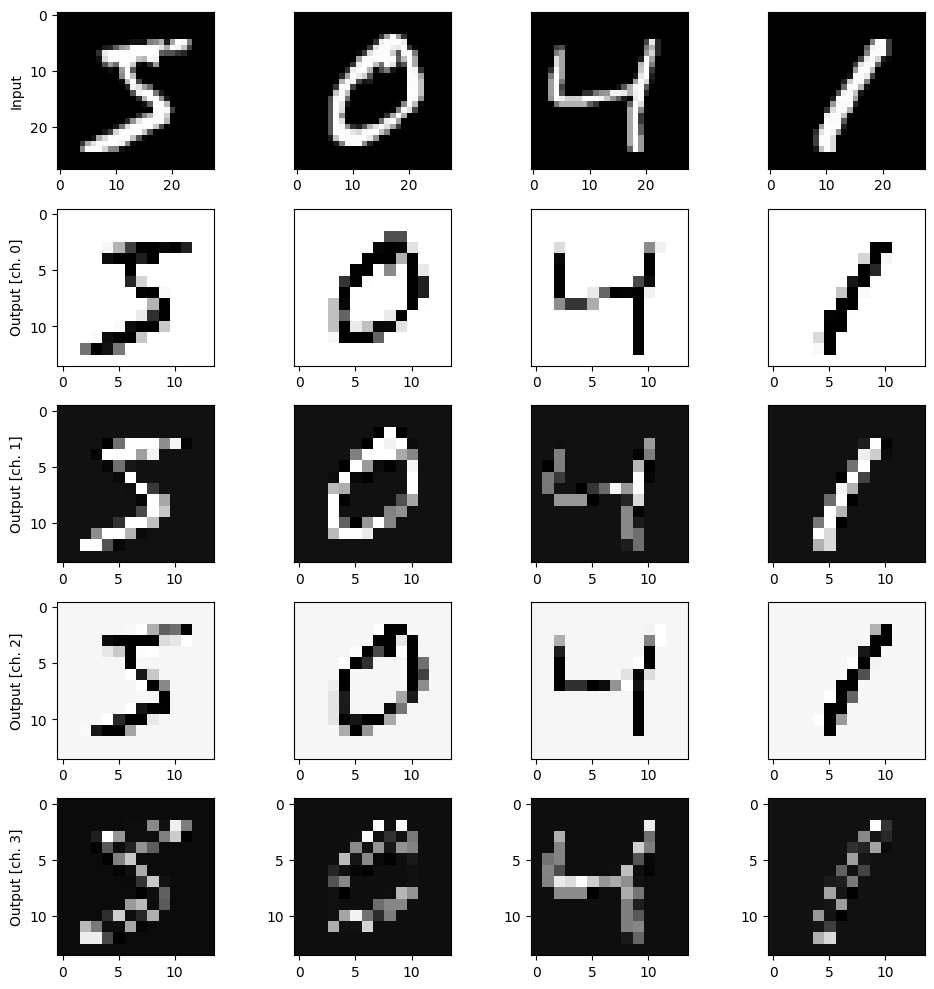

In [18]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(x_train[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## 7. Hybrid Model Architecture (Flax)
We define a classical fully connected network using **Flax**. This model takes the flattened quantum features as input and outputs logits for the 10 MNIST classes.

In [19]:
# 1. Define the Model (Stateless Architecture)
class MyModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        # Flatten the input: (Batch, Height, Width, Channels) -> (Batch, Features)
        x = x.reshape((x.shape[0], -1))
        # Dense layer to 10 classes (Output Logits)
        x = nn.Dense(features=10)(x)
        return x

## 8. Optimization & Evaluation Steps
We define the functional training logic required by JAX:
* **`train_step`**: Computes the loss and gradients using `jax.value_and_grad`, then updates the model parameters (`TrainState`) using Optax.
* **`eval_step`**: Computes metrics without updating parameters.

Both functions are decorated with `@jax.jit` to compile them into optimized XLA kernels.

In [20]:
@jax.jit
def train_step(state, batch_images, batch_labels):
    """
    Performs a single optimization step.
    Calculates loss and gradients, then updates the TrainState.
    """
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_images)
        # Use softmax_cross_entropy with integer labels (expects logits)
        loss = optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=batch_labels
        ).mean()
        return loss, logits

    # Compute gradients and return auxiliary data (logits)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    
    # Update state with gradients (Optax optimizer logic applied here)
    state = state.apply_gradients(grads=grads)
    
    # Compute metrics
    accuracy = jnp.mean(jnp.argmax(logits, -1) == batch_labels)
    return state, loss, accuracy

@jax.jit
def eval_step(state, batch_images, batch_labels):
    """
    Evaluates the model on a batch without updating parameters.
    """
    logits = state.apply_fn({'params': state.params}, batch_images)
    loss = optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch_labels
    ).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == batch_labels)
    return loss, accuracy

In [21]:
def create_train_state(rng, input_shape, learning_rate=0.01):
    """Creates the initial TrainState (parameters + optimizer)."""
    model = MyModel()
    # Initialize parameters using a dummy input
    params = model.init(rng, jnp.ones(input_shape))['params']
    # Define optimizer (Adam)
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

## 9. Custom Training Loop
Unlike Keras, Flax requires an explicit training loop. This function manages the epoch iterations, data shuffling, batching, and state updates. It returns the final trained state and a history dictionary for plotting.

In [22]:
def fit_model(train_x, train_y, test_x, test_y, epochs, batch_size, rng_seed):
    # Data preparation
    num_samples = train_x.shape[0]
    steps_per_epoch = num_samples // batch_size
    input_shape = (1, *train_x.shape[1:]) # (1, H, W, C)
    
    # Initialize State
    rng = jax.random.key(rng_seed)
    init_rng, train_rng = jax.random.split(rng)
    state = create_train_state(init_rng, input_shape)
    
    history = {'loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        # Shuffle data at start of epoch
        train_rng, shuffle_rng = jax.random.split(train_rng)
        perms = jax.random.permutation(shuffle_rng, num_samples)
        perms = perms[:steps_per_epoch * batch_size] # Skip incomplete batch
        
        # Reshape for easy batching
        epoch_perms = perms.reshape((steps_per_epoch, batch_size))
        
        batch_losses = []
        batch_accs = []

        # --- Train Loop ---
        for batch_idx in epoch_perms:
            batch_imgs = train_x[batch_idx]
            batch_lbls = train_y[batch_idx]
            state, loss, acc = train_step(state, batch_imgs, batch_lbls)
            batch_losses.append(loss)
            batch_accs.append(acc)
            
        # --- Validation Loop ---
        # (Eval on full test set at once since it's small, else batch this too)
        val_loss, val_acc = eval_step(state, test_x, test_y)
        
        # Logging
        train_loss = np.mean(batch_losses)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)
        
        if epoch % 2 == 0: # Print every 5 epochs
            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | "
                  f"Val Acc: {val_acc:.4f}")
            
    return state, history

## 10. Experiment Execution
We now train two models for comparison:
1.  **Quantum Model:** Trains on the `q_train_images` (features extracted by the quantum circuit).
2.  **Classical Model:** Trains on the raw `x_train` images (standard pixel data).

In [23]:
print("\n--- Training Quantum Model (JAX) ---")
# Note: q_train_images must be generated by the PREPROCESS loop first
q_state, q_history = fit_model(
    q_train_images, y_train, 
    q_test_images, y_test, 
    epochs=n_epochs, batch_size=4, rng_seed=42
)


--- Training Quantum Model (JAX) ---
Epoch 1/50 | Loss: 6.3252 | Val Loss: 3.1705 | Val Acc: 0.3667
Epoch 3/50 | Loss: 0.7111 | Val Loss: 1.9384 | Val Acc: 0.3333
Epoch 5/50 | Loss: 0.1232 | Val Loss: 1.7477 | Val Acc: 0.5667
Epoch 7/50 | Loss: 0.0156 | Val Loss: 1.1356 | Val Acc: 0.7333
Epoch 9/50 | Loss: 0.0109 | Val Loss: 1.2403 | Val Acc: 0.6667
Epoch 11/50 | Loss: 0.0081 | Val Loss: 1.1727 | Val Acc: 0.6667
Epoch 13/50 | Loss: 0.0066 | Val Loss: 1.1571 | Val Acc: 0.6667
Epoch 15/50 | Loss: 0.0063 | Val Loss: 1.1436 | Val Acc: 0.6667
Epoch 17/50 | Loss: 0.0058 | Val Loss: 1.1511 | Val Acc: 0.7000
Epoch 19/50 | Loss: 0.0054 | Val Loss: 1.1367 | Val Acc: 0.7333
Epoch 21/50 | Loss: 0.0048 | Val Loss: 1.1625 | Val Acc: 0.6667
Epoch 23/50 | Loss: 0.0046 | Val Loss: 1.1458 | Val Acc: 0.7333
Epoch 25/50 | Loss: 0.0041 | Val Loss: 1.1625 | Val Acc: 0.7000
Epoch 27/50 | Loss: 0.0037 | Val Loss: 1.1868 | Val Acc: 0.6667
Epoch 29/50 | Loss: 0.0036 | Val Loss: 1.1564 | Val Acc: 0.7333
Epoch 3

In [24]:
print("\n--- Training Classical Model (JAX) ---")
c_state, c_history = fit_model(
    x_train, y_train, 
    x_test, y_test, 
    epochs=n_epochs, batch_size=4, rng_seed=84
)


--- Training Classical Model (JAX) ---
Epoch 1/50 | Loss: 2.4033 | Val Loss: 1.5894 | Val Acc: 0.4667
Epoch 3/50 | Loss: 0.1991 | Val Loss: 1.0232 | Val Acc: 0.7667
Epoch 5/50 | Loss: 0.0557 | Val Loss: 0.9771 | Val Acc: 0.7333
Epoch 7/50 | Loss: 0.0327 | Val Loss: 0.9648 | Val Acc: 0.7333
Epoch 9/50 | Loss: 0.0239 | Val Loss: 0.9830 | Val Acc: 0.7333
Epoch 11/50 | Loss: 0.0169 | Val Loss: 0.9609 | Val Acc: 0.7667
Epoch 13/50 | Loss: 0.0141 | Val Loss: 0.9685 | Val Acc: 0.7333
Epoch 15/50 | Loss: 0.0109 | Val Loss: 0.9782 | Val Acc: 0.7333
Epoch 17/50 | Loss: 0.0100 | Val Loss: 0.9791 | Val Acc: 0.7333
Epoch 19/50 | Loss: 0.0084 | Val Loss: 0.9764 | Val Acc: 0.7667
Epoch 21/50 | Loss: 0.0076 | Val Loss: 0.9778 | Val Acc: 0.7667
Epoch 23/50 | Loss: 0.0068 | Val Loss: 0.9837 | Val Acc: 0.7333
Epoch 25/50 | Loss: 0.0059 | Val Loss: 0.9947 | Val Acc: 0.7333
Epoch 27/50 | Loss: 0.0052 | Val Loss: 0.9930 | Val Acc: 0.7333
Epoch 29/50 | Loss: 0.0048 | Val Loss: 0.9994 | Val Acc: 0.7333
Epoch

## 11. Results & Comparison
We plot the validation accuracy and loss for both models. 

*Note: For this demonstration, we used a very small subset of MNIST (50 samples). As a result, validation metrics may be noisy. In a full-scale scenario, the quantum features often provide distinct learnability advantages or faster convergence in specific regimes.*

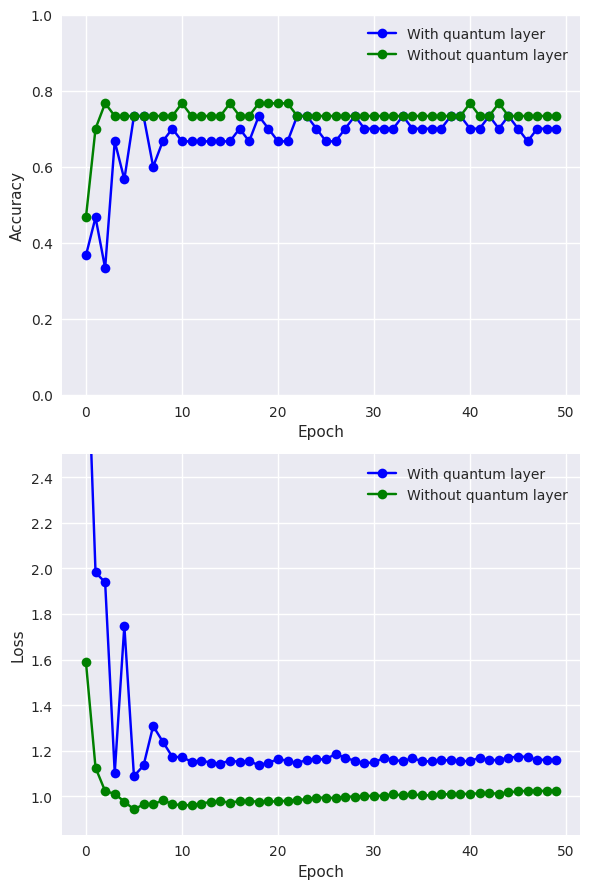

In [25]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()